In [0]:
#Importamos la segunda versión de tensorflow
%tensorflow_version 2.x

In [0]:
#Instalamos las dependencias necesarias que no posee Google Colab.
!pip install mlxtend --upgrade --no-deps
!pip install bayesian-optimization

In [0]:
#Importamos los paquetes necesarios para el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from sklearn import preprocessing
from scipy import stats
from array import array
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_confusion_matrix
from bayes_opt import BayesianOptimization
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
from keras.regularizers import l1
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,LSTM, MaxPool2D, Dropout, Flatten, Activation, LeakyReLU, ReLU
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
#Descargamos el set de datos subido previamente al Google Drive (Tarda menos que descargarlo directamente de la página).
path_train = "/content/drive/My Drive/TFG/UNSW_NB15_training-set.csv"
path_test = "/content/drive/My Drive/TFG/UNSW_NB15_testing-set.csv"

#Leemos los datos
df_train=pd.read_csv(path_train,dtype='unicode')
df_test=pd.read_csv(path_test,dtype='unicode')

#Quitamos las columnas no necesarias
df_train.drop('id', axis=1, inplace=True)
df_train.drop('label', axis=1, inplace=True)
df_test.drop('id', axis=1, inplace=True)
df_test.drop('label', axis=1, inplace=True)

In [0]:
#Concatenamos el set de entrenamiento y el de test para manipular directamente el conjunto.
df = pd.concat([df_train,df_test],axis=0)
print(df.shape)
df[:5]

In [0]:
#Número de valores por clase
attack_cat = df['attack_cat'].value_counts()

count_class_Normal = attack_cat[0]
count_class_Generic = attack_cat[1]
count_class_Exploits = attack_cat[2]
count_class_Fuzzers = attack_cat[3]
count_class_Reconnaissance = attack_cat[4]
count_class_DoS = attack_cat[5]
count_class_Backdoors = attack_cat[6]
count_class_Analysis = attack_cat[7]
count_class_Shellcode = attack_cat[8]
count_class_Worms = attack_cat[9]

#División del dataset por clases.
df_class_Normal = df[df['attack_cat'] == 'Normal']
df_class_Generic = df[df['attack_cat'] == 'Generic']
df_class_Exploits = df[df['attack_cat'] == 'Exploits']
df_class_Fuzzers = df[df['attack_cat'] == 'Fuzzers']
df_class_DoS = df[df['attack_cat'] == 'DoS']
df_class_Reconnaissance = df[df['attack_cat'] == 'Reconnaissance']
df_class_Backdoor = df[df['attack_cat'] == 'Backdoor']
df_class_Analysis = df[df['attack_cat'] == 'Analysis']
df_class_Shellcode = df[df['attack_cat'] == 'Shellcode']
df_class_Worms = df[df['attack_cat'] == 'Worms']

#Under-sampling las categorías Normal, Generic, Exploits, Fuzzers, DoS, Reconnaissance, Backdoor, Analysis y Shellcode aleatoriamente a 1000 muestras
df_class_Normal = df_class_Normal.sample(1000)
df_class_Generic = df_class_Generic.sample(1000)
df_class_Exploits = df_class_Exploits.sample(1000)
df_class_Fuzzers = df_class_Fuzzers.sample(1000)
df_class_DoS = df_class_DoS.sample(1000)
df_class_Reconnaissance = df_class_Reconnaissance.sample(1000)
df_class_Backdoor = df_class_Backdoor.sample(1000)
df_class_Analysis = df_class_Analysis.sample(1000)
df_class_Shellcode = df_class_Shellcode.sample(1000)

#Concatenado
df = pd.concat([df_class_Normal,df_class_Generic,df_class_Exploits,df_class_Fuzzers,df_class_DoS,df_class_Reconnaissance,df_class_Backdoor,df_class_Analysis,df_class_Shellcode,df_class_Worms], axis=0)

Shape of dataFrame: (9174, 43) 

Number of samples per attack


Shellcode         1000
Normal            1000
Analysis          1000
DoS               1000
Exploits          1000
Generic           1000
Fuzzers           1000
Reconnaissance    1000
Backdoor          1000
Worms              174
Name: attack_cat, dtype: int64


Plotting balance of dataFrame


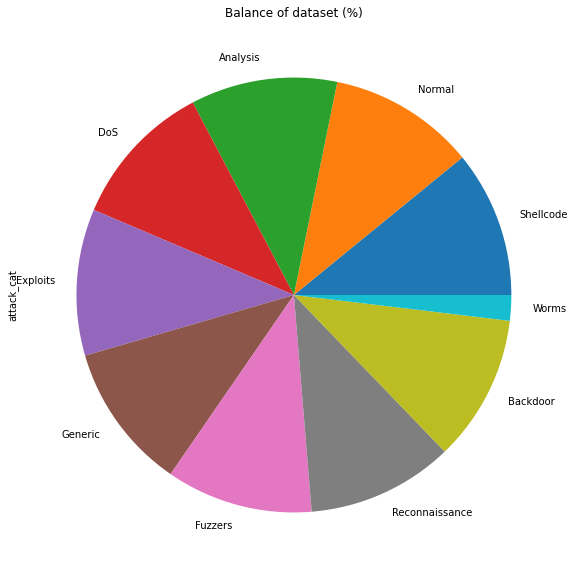

In [0]:
#Visualización en una gráfica circular del peso de cada clase
print("Shape of dataFrame: {} \n".format(df.shape))
print("Number of samples per attack")
display(df['attack_cat'].value_counts())
print("")
print("Plotting balance of dataFrame")
df_plot = (df['attack_cat'].value_counts(normalize=True) *100)
df_plot.plot(kind='pie',figsize=(10,10),title='Balance of dataset (%)')

In [0]:
#Conversión de los datos tipo string a enteros en un rango entre 0 y 255 (1 Byte de información)
def encode_string_byte (df,name):
  df[name] = LabelEncoder().fit_transform(df[name])

encode_string_byte (df,'proto')
encode_string_byte (df,'state') 
encode_string_byte (df,'service') 

display(df.head())
print("")
print("Proto column --> Max value: {} Min value: {} ".format(max(df['proto']),min(df['proto'])))
print("State column --> Max value: {} Min value: {} ".format(max(df['state']),min(df['state'])))
print("Service column --> Max value: {} Min value: {} ".format(max(df['service']),min(df['service'])))

In [0]:
#Normalización de los números enteros en valores decimales en rango entre 0 y 1
def numerical_minmax_normalization (df, name):
  x = df[name].values.reshape(-1,1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df[name] = x_scaled

numerical_minmax_normalization(df,'dur')
numerical_minmax_normalization(df,'spkts')
numerical_minmax_normalization(df,'dpkts')
numerical_minmax_normalization(df,'sbytes')
numerical_minmax_normalization(df,'dbytes')
numerical_minmax_normalization(df,'rate')
numerical_minmax_normalization(df,'sttl')
numerical_minmax_normalization(df,'dttl')
numerical_minmax_normalization(df,'sload')
numerical_minmax_normalization(df,'dload')
numerical_minmax_normalization(df,'sloss')
numerical_minmax_normalization(df,'dloss')
numerical_minmax_normalization(df,'sinpkt')
numerical_minmax_normalization(df,'dinpkt')
numerical_minmax_normalization(df,'sjit')
numerical_minmax_normalization(df,'djit')
numerical_minmax_normalization(df,'swin')
numerical_minmax_normalization(df,'stcpb')
numerical_minmax_normalization(df,'dtcpb')
numerical_minmax_normalization(df,'dwin')
numerical_minmax_normalization(df,'tcprtt')
numerical_minmax_normalization(df,'synack')
numerical_minmax_normalization(df,'ackdat')
numerical_minmax_normalization(df,'smean')
numerical_minmax_normalization(df,'dmean')
numerical_minmax_normalization(df,'trans_depth')
numerical_minmax_normalization(df,'response_body_len')
numerical_minmax_normalization(df,'ct_srv_src')
numerical_minmax_normalization(df,'ct_state_ttl')
numerical_minmax_normalization(df,'ct_dst_ltm')
numerical_minmax_normalization(df,'ct_src_dport_ltm')
numerical_minmax_normalization(df,'ct_dst_sport_ltm')
numerical_minmax_normalization(df,'ct_dst_src_ltm')
numerical_minmax_normalization(df,'is_ftp_login')
numerical_minmax_normalization(df,'ct_ftp_cmd')
numerical_minmax_normalization(df,'ct_flw_http_mthd')
numerical_minmax_normalization(df,'ct_src_ltm')
numerical_minmax_normalization(df,'ct_srv_dst')
numerical_minmax_normalization(df,'is_sm_ips_ports')

df.head()

In [0]:
#Mapeo de los valores normalizados del paso anterior a valores enteros entre 0 y 255 (1 Byte de información)
def numerical_split_ohe (df,name):
  pd_to_np = df[name].tolist()
  np_split = []
  
  categories = np.linspace(0, 1, num=256,endpoint=False)
  quantization = range(0,256)

  for value in pd_to_np:
    for i in range(len(categories)-1):
      if (categories[i] <= float(value) <= categories[i+1]):
        np_split.append(quantization[i])
        break
      if (float(value) > categories[-1]):
        np_split.append(quantization[-1])
        break
  
  df[name] = np_split


numerical_split_ohe(df,'dur')
numerical_split_ohe(df,'spkts')
numerical_split_ohe(df,'dpkts')
numerical_split_ohe(df,'sbytes')
numerical_split_ohe(df,'dbytes')
numerical_split_ohe(df,'rate')
numerical_split_ohe(df,'sttl')
numerical_split_ohe(df,'dttl')
numerical_split_ohe(df,'sload')
numerical_split_ohe(df,'dload')
numerical_split_ohe(df,'sloss')
numerical_split_ohe(df,'dloss')
numerical_split_ohe(df,'sinpkt')
numerical_split_ohe(df,'dinpkt')
numerical_split_ohe(df,'sjit')
numerical_split_ohe(df,'djit')
numerical_split_ohe(df,'swin')
numerical_split_ohe(df,'stcpb')
numerical_split_ohe(df,'dtcpb')
numerical_split_ohe(df,'dwin')
numerical_split_ohe(df,'tcprtt')
numerical_split_ohe(df,'synack')
numerical_split_ohe(df,'ackdat')
numerical_split_ohe(df,'smean')
numerical_split_ohe(df,'dmean')
numerical_split_ohe(df,'trans_depth')
numerical_split_ohe(df,'response_body_len')
numerical_split_ohe(df,'ct_srv_src')
numerical_split_ohe(df,'ct_state_ttl')
numerical_split_ohe(df,'ct_dst_ltm')
numerical_split_ohe(df,'ct_src_dport_ltm')
numerical_split_ohe(df,'ct_dst_sport_ltm')
numerical_split_ohe(df,'ct_dst_src_ltm')
numerical_split_ohe(df,'is_ftp_login')
numerical_split_ohe(df,'ct_ftp_cmd')
numerical_split_ohe(df,'ct_flw_http_mthd')
numerical_split_ohe(df,'ct_src_ltm')
numerical_split_ohe(df,'ct_srv_dst')
numerical_split_ohe(df,'is_sm_ips_ports')

display(df.head())

In [0]:
#Quitando la columna attack_cat y guardandola en la variable y.
y_column = df['attack_cat']
df.drop('attack_cat',axis=1,inplace=True)
dummies = pd.get_dummies(y_column) 
y = dummies.values

print(y[:5])
display(dummies.head())

In [0]:
#Balanceo del dataset mediante SMOTE (1000 por cada clase) y normalización entre -0,5 y 0,5
byte_images = df.to_numpy()
x = []
for image in np.array(byte_images):
  x.append((image/255 - 0.5))
sm = SMOTE(random_state=0)
x, y = sm.fit_sample(x, y)
x = np.array(x)

In [0]:
#Separación del dataset en un set de entrenamiento y otro de validación.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(x,y):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]

In [0]:
#Transformación del array 'y' en un valor úncio
def y_transform(y_train):
  y_train_rfe = []
  for value in y_train:
    y_train_rfe.append(list(value).index(1))
  return y_train_rfe


In [0]:
#Proceso de selección de caraceterísitcas mediante RFE. Estimador RandomForestClassifier.
y_rfe = y_transform(y)
for index in range(1,42):
  sel = RFE(RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1),n_features_to_select=index)
  sel.fit(x,y_rfe)
  print("Number of selected features: {}".format(index))
  features =[]
  for i,value in enumerate(sel.support_):
    if value:
      features.append(i)
  print("Features: {}".format([list(list(df.columns)[index_value] for index_value in features)]))

Number of selected features: 1
Features: [['smean']]
Number of selected features: 2
Features: [['smean', 'dmean']]
Number of selected features: 3
Features: [['smean', 'dmean', 'ct_srv_dst']]
Number of selected features: 4
Features: [['synack', 'smean', 'dmean', 'ct_srv_dst']]
Number of selected features: 5
Features: [['proto', 'synack', 'smean', 'dmean', 'ct_srv_dst']]
Number of selected features: 6
Features: [['proto', 'synack', 'smean', 'dmean', 'ct_dst_src_ltm', 'ct_srv_dst']]
Number of selected features: 7
Features: [['proto', 'sttl', 'synack', 'smean', 'dmean', 'ct_dst_src_ltm', 'ct_srv_dst']]
Number of selected features: 8
Features: [['proto', 'service', 'sttl', 'synack', 'smean', 'dmean', 'ct_dst_src_ltm', 'ct_srv_dst']]
Number of selected features: 9
Features: [['dur', 'proto', 'service', 'sttl', 'synack', 'smean', 'dmean', 'ct_dst_src_ltm', 'ct_srv_dst']]
Number of selected features: 10
Features: [['dur', 'proto', 'service', 'sttl', 'sload', 'synack', 'smean', 'dmean', 'ct_dst